# Navigation par corrélation de terrain

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from numpy import random
from numpy.random import multinomial
import numpy.linalg
import math

from scipy import interpolate
from mpl_toolkits import mplot3d
from matplotlib import cm


dict_keys(['__header__', '__version__', '__globals__', 'ans', 'dt_resol', 'h_MNT', 'i', 'j', 'lat_reel', 'rayon', 'resol_ang', 'x_MNT', 'y_MNT'])
(1, 799)


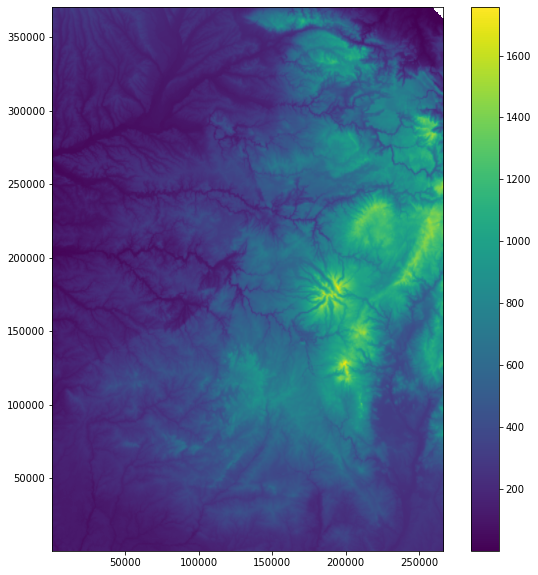

In [3]:
data = loadmat('carte_centreMetres.mat');
print(data.keys())
h_mnt = data["h_MNT"]
h_mnt = np.flip(h_mnt,axis = 0)
x_mnt = data["x_MNT"]
y_mnt = data["y_MNT"]
print(np.shape(x_mnt))
plt.figure(figsize = (10,10))
plt.imshow(h_mnt,extent = [x_mnt[0,0],x_mnt[0,-1],y_mnt[0,0],y_mnt[0,-1]])
plt.colorbar()



In [5]:
plt.plot(x_red[0])
plt.title("x_red")
plt.show()
plt.plot(y_red[0])
plt.title("y_red")
plt.show()

NameError: name 'x_red' is not defined

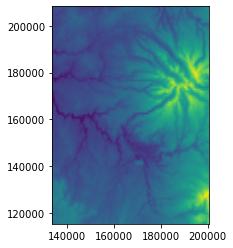

In [6]:
y_mnt_1 = np.flip(y_mnt[0])
indice_y_min=350
indice_y_max=550
indice_x_min=400
indice_x_max=600
x_red = x_mnt[:,indice_x_min:indice_x_max]
y_red = y_mnt[:,indice_y_min:indice_y_max]


exten = [x_mnt[0,indice_x_min],x_mnt[0,indice_x_max],y_mnt_1[indice_y_max],y_mnt_1[indice_y_min]]
h_red = h_mnt[indice_y_min:indice_y_max,indice_x_min:indice_x_max]
plt.imshow(h_red, extent = exten)
plt.show()

In [7]:
def redistribution(X,w):
    w_normalise = w/np.sum(w)
    shape = np.shape(X)
    n = shape[0]
    multinom = multinomial(n,w_normalise)
    X_redistribue = []
    for i in range(n):
        for j in range(multinom[i]):
            X_redistribue.append(X[i]) 
    X_redistribue = np.array(X_redistribue)
    return(X_redistribue)

In [8]:
def reechantillonage(X_redistribue,h):
    shape = np.shape(X_redistribue)
    n = shape[0]
    p = shape[1]
    X_reechant = np.zeros((n,p))
    cov = np.cov(X_redistribue.T)
    gamma = np.linalg.cholesky(cov)
    for i in range(n):
        X_reechant[i]= X_redistribue[i] + h*np.dot(gamma,np.random.normal(0,1,p))
    return(X_reechant)

### Constantes

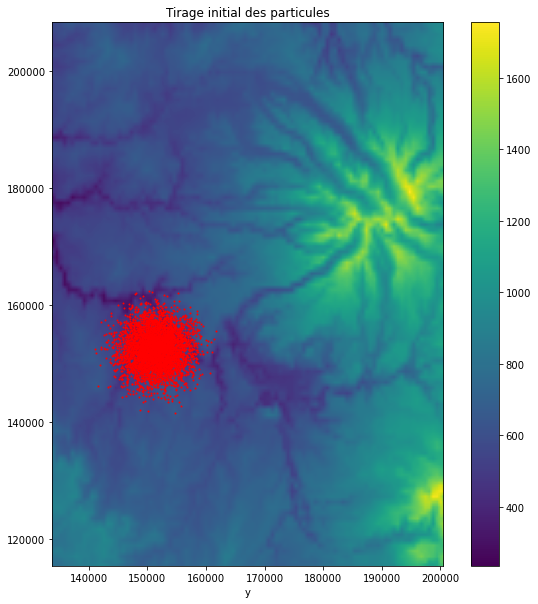

In [29]:
# constantes
from matplotlib import markers
from matplotlib.lines import lineStyles


dt = 1
phi = np.identity(6)
for i in range(3):
    phi[i,i+3]=dt
incertitude_x = 3000
incertitude_y = 3000
incertitude_z = 500
incertitude_vitesse = 5
vitavion = 300*1000/3600
capavion = 45*math.pi/180
X0_vrai =np.array([150*1000,150*1000,8000,vitavion*math.cos(capavion),vitavion*math.sin(capavion),0])
sigma_bruit =30
array_incertitude = np.array([incertitude_x,incertitude_y,incertitude_z,incertitude_vitesse,incertitude_vitesse,incertitude_vitesse])
P0 = np.diag(array_incertitude)
racine_P0 = np.sqrt(P0)
pseudoX0 = X0_vrai+2*np.array([np.random.uniform(0,incertitude) for incertitude in array_incertitude])- array_incertitude
N_part = 5000
particules_0 = np.array([pseudoX0+ np.dot(P0,np.random.normal(0,1,6)) for i in range(N_part)])
T=720
plt.figure(figsize = (10,10))
plt.imshow(h_red,extent = exten)
plt.title("Tirage initial des particules")
plt.xlabel("x")
plt.xlabel("y")
plt.plot(particules_0[:,0],particules_0[:,1],'r',linestyle ="",marker='o', markersize='1')
plt.colorbar()



In [10]:
def dynamique(X0,phi,T):
    n,= np.shape(X0)
    X = np.zeros((T,n))
    X[0]=X0
    for i in range(1,T):
        X[i]=np.dot(phi,X[i-1])
    return(X)    

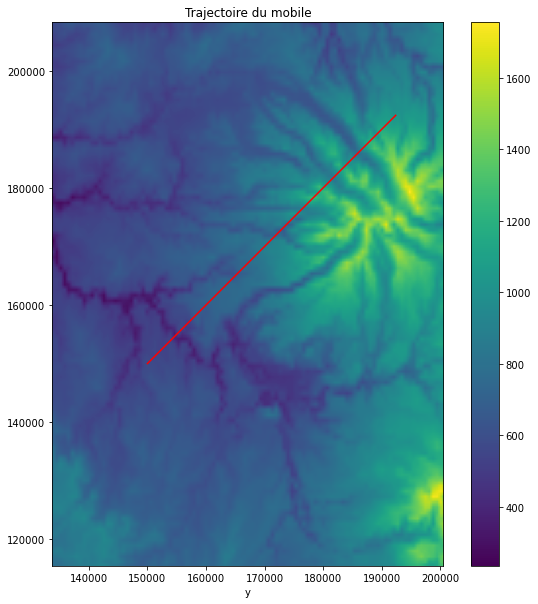

In [11]:
trajectoire = dynamique(X0_vrai,phi,T)
plt.figure(figsize = (10,10))
plt.imshow(h_red,extent = exten)
plt.title("Trajectoire du mobile")
plt.xlabel("x")
plt.xlabel("y")
plt.plot(trajectoire[:,0],trajectoire[:,1],'r')
plt.colorbar()

In [12]:
def mesure_bruitee(trajectoire,sigma_bruit):
    n,p = np.shape(trajectoire)
    mes = np.zeros(n)
    for i in range(n):
        mes[i]= mesure(trajectoire[i,0],trajectoire[i,1],trajectoire[i,2])+np.random.normal(0,sigma_bruit)
    return(mes)

def indice(x,y):
    delta_x =x_mnt[0,-1]-x_mnt[0,0]
    delta_y = y_mnt[0,-1]-y_mnt[0,0]
    indice_x = (x-x_mnt[0,0])*799/(delta_x)
    indice_y = (y-y_mnt[0,0])*799/(delta_y)
    return(max(0,min(int(indice_x),798)),798-max(0,min(int(indice_y),798)))

def mesure(x,y,z):
    indice_x,indice_y = indice(x,y)
    return(z-h_mnt[indice_x,indice_y])



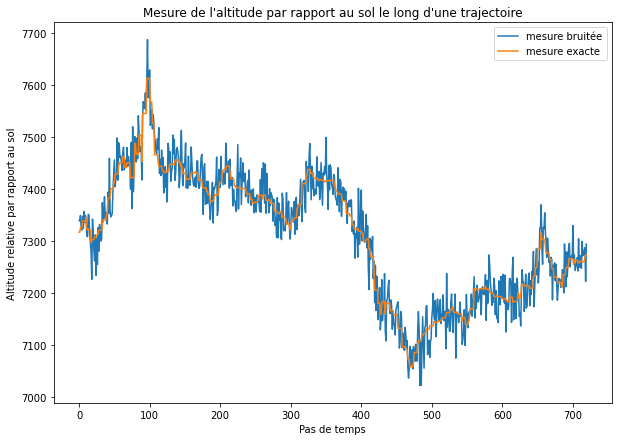

In [13]:
mesure_bruitees_traj = mesure_bruitee(trajectoire,sigma_bruit)
mesure_exactes = np.array([mesure(etat[0],etat[1],etat[2]) for etat in trajectoire])
plt.figure(figsize=(10,7))
plt.plot(mesure_bruitees_traj)
plt.plot(mesure_exactes)
plt.title("Mesure de l'altitude par rapport au sol le long d'une trajectoire")
plt.xlabel("Pas de temps")
plt.ylabel('Altitude relative par rapport au sol')
plt.legend(['mesure bruitée','mesure exacte'])

### iterpolation

In [14]:
absc = np.arange(0,799,1)
ord = np.arange(0,799,1) 
modele_interpole = interpolate.interp2d(absc,ord,h_mnt,kind = 'cubic')
modele_interpole(500,500)

array([nan])

### filtrage particulaire

In [15]:
def vraissemblance(etat,observation):
    return(noyeau_gaussien(observation-mesure(etat[0],etat[1],etat[2])))

def noyeau_gaussien(x):
    return(np.exp((-x**2)/(2*(sigma_bruit**2)))/np.sqrt(2*math.pi*sigma_bruit))

def filtrage_particulaire(particules_0,mesure_traj,N_th,phi,T,h):
    n,p = np.shape(trajectoire)
    N_part,p_part = np.shape(particules_0)
    particules = np.zeros((T,N_part,p))
    particules[0]= particules_0
    weights = np.ones(N_part)/N_part
    particules_temp = np.zeros((N_part,p))
    for i in range(1,T):
        #evolution/prediction
        particules_temp = np.zeros((N_part,p))
        for j in range(N_part):
            particules_temp[j] = np.dot(phi,particules[i-1,j])
            #correction
            weights[j]=vraissemblance(particules_temp[j],mesure_traj[i])
        weights = weights/np.sum(weights)
        X_redistribue = redistribution(particules_temp,weights)
        critère = 1/np.sum(weights**2)
        if critère <=N_th:
            X_redistribue = reechantillonage(X_redistribue,h)
        particules[i]=X_redistribue
    return(particules)


In [16]:
h_opt = (4/3)**(1/5)*N_part**(-1/5)
print(h_opt)

0.19283850080052542


In [63]:
particules = filtrage_particulaire(particules_0, mesure_bruitees_traj, 0.6*N_part,phi,T,h=h_opt)

### Estimation de la position par le barycentre du nuage de points 

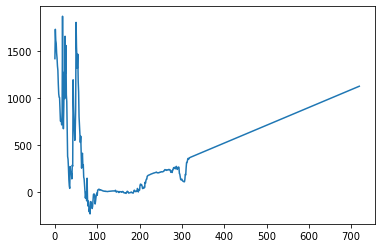

In [64]:
barycentre = np.mean(particules, axis =1)
barycentre_pos = barycentre[:,:3]
trajectoire_pos = trajectoire[:,:3]
diff =barycentre_pos-trajectoire_pos
plt.plot(diff[:,0])
plt.show()
distance = np.linalg.norm(barycentre_pos-trajectoire_pos,axis=1)
# plt.plot(distance)
# plt.show()



In [82]:
with open('particules.npy','wb') as f : 
    np.save(f,particules)
with open('trajectoire.npy','wb') as f : 
    np.save(f,trajectoire)
# with open('particules.npy','rb') as f:
#     particules = np.load(f)
# with open('trajectoire.npy','rb') as f:
#     trajectoire = np.load(f)

In [56]:
def figure(iteration, particules, trajectoire): 
    barycentre = np.mean(particules, axis =1)
    plt.figure(figsize = (5,5))
    plt.title("Trajectoire et particules, itération : "+str(iteration))
    plt.imshow(h_mnt[indice_y_min:indice_y_max,indice_x_min:indice_x_max], extent = [x_mnt[0,indice_x_min],x_mnt[0,indice_x_max],y_mnt_1[indice_y_max],y_mnt_1[indice_y_min]])
    plt.scatter(particules[iteration,:,0],particules[iteration,:,1],c='r',s=1)
    plt.colorbar()
    plt.plot(trajectoire[:iteration,0], trajectoire[:iteration,1],'g')
    plt.plot(barycentre[:iteration,0], barycentre[:iteration,1],'purple')
    plt.show()

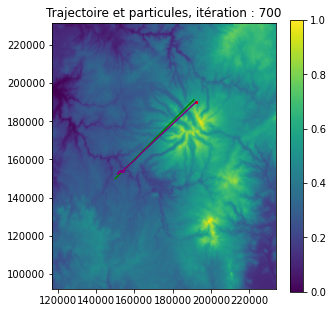

In [65]:
# for i in range (40):
    # figure(i*10, particules, trajectoire)
figure(700, particules, trajectoire)

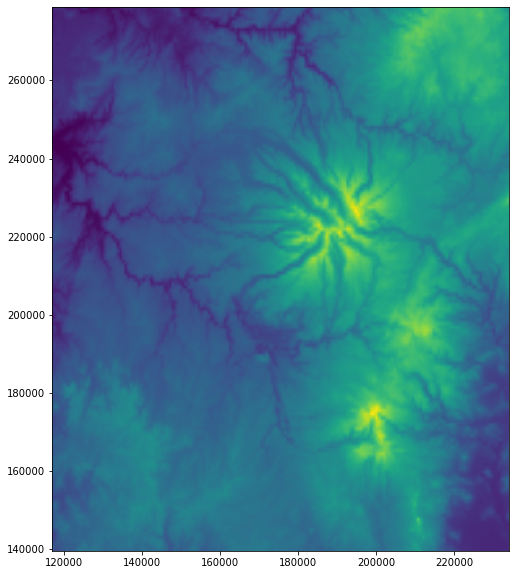

In [20]:
plt.figure(figsize = (10,10))
indice_x_min, indice_x_max = 350,700
indice_y_min, indice_y_max = 300,600
extend = [x_mnt[0,indice_x_min],x_mnt[0,indice_x_max],y_mnt[0,indice_y_min],y_mnt[0,indice_y_max]]

plt.imshow(h_mnt[indice_y_min:indice_y_max,indice_x_min:indice_x_max],extent = extend)

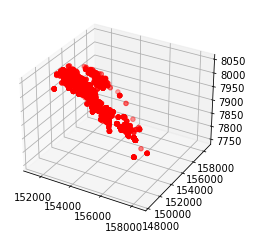

In [21]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(particules[40,:,0],particules[40,:,1],particules[40,:,2],c='r')
# print(np.shape(particules[40,:,0]))

In [51]:
def figure3D(iteration):
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    x,y = np.meshgrid(x_red,y_red)

    mappable = plt.cm.ScalarMappable()
    mappable.set_array(h_red)
    ax.plot_surface(x, y, h_red, cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
    ax.scatter3D(particules[iteration,:,0],particules[iteration,:,1],particules[iteration,:,2],c='r',s=1)
    ax.plot3D(trajectoire[:iteration,0],trajectoire[:iteration,1],trajectoire[:iteration,2],'g')
    ax.plot3D(barycentre[:iteration,0], barycentre[:iteration,1],barycentre[:iteration,2],'purple')

    mappable.set_clim(200, 1200)
    plt.colorbar(mappable)
    plt.title("Itération : "+str(iteration))
    plt.show()


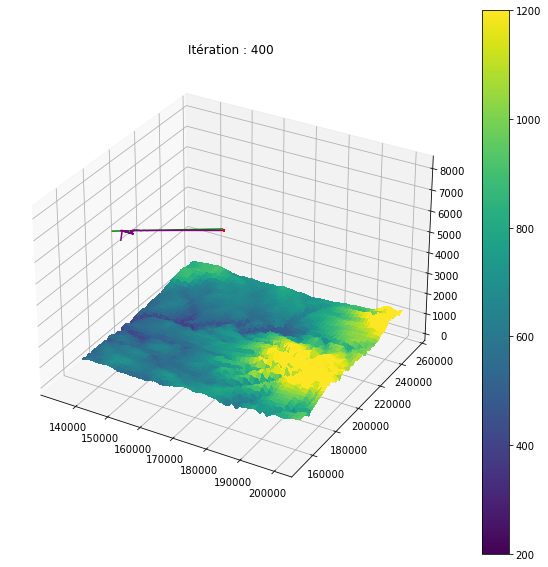

In [81]:
figure3D(400)

In [66]:
def ke(x):
    if np.abs(x)>=1:
        return(0)
    else : 
        return 3*(1-x*x)/4

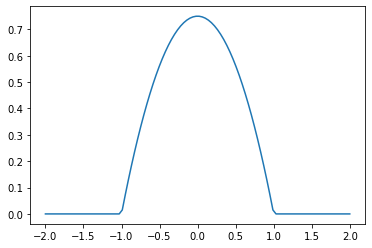

In [83]:
t = np.linspace(-2,2,100)
epanechikov = np.array([ke(i) for i in t])
plt.plot(t,epanechikov)

In [98]:
def methode_rejet(q_tilde): 
    """genere une va distribuée selon la densité q_tilde, selon la méthode du rejet"""
    X = np.random.uniform(-1,1,1)
    U = np.random.uniform(0,1,1)
    C= q_tilde(0)
    nombre_de_tentatives = 1
    while q_tilde(X)<C*U : 
        X = np.random.uniform(-1,1,1)
        U = np.random.uniform(0,1,1)
        nombre_de_tentatives +=1
    return(X,nombre_de_tentatives)

(array([ 0.,  2.,  1.,  7.,  7.,  8., 13., 18.,  5., 15., 15., 12., 24.,
        15., 19., 19., 33., 25., 33., 29., 30., 26., 26., 33., 28., 35.,
        32., 30., 45., 35., 35., 36., 42., 47., 47., 52., 39., 53., 46.,
        38., 35., 48., 47., 46., 54., 48., 61., 52., 54., 57., 57., 54.,
        54., 52., 67., 64., 73., 71., 52., 62., 62., 59., 53., 84., 64.,
        71., 67., 48., 72., 71., 65., 69., 56., 63., 65., 71., 73., 74.,
        77., 66., 76., 74., 83., 60., 97., 74., 69., 75., 67., 68., 72.,
        63., 93., 58., 75., 74., 63., 78., 75., 75., 69., 83., 75., 69.,
        61., 60., 69., 71., 82., 70., 71., 82., 80., 62., 69., 68., 84.,
        83., 63., 76., 76., 90., 65., 66., 67., 71., 64., 67., 69., 59.,
        67., 75., 72., 62., 61., 60., 61., 69., 61., 67., 58., 85., 73.,
        60., 72., 60., 71., 53., 50., 57., 60., 63., 61., 63., 54., 48.,
        48., 39., 55., 49., 45., 52., 46., 50., 45., 47., 44., 41., 33.,
        31., 32., 38., 43., 45., 34., 33., 38., 26.

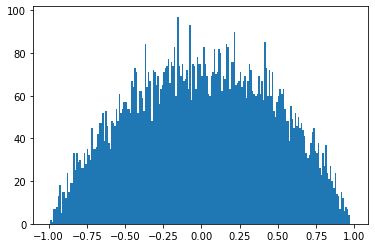

In [99]:
epan  = np.array([methode_rejet(ke)[0] for k in range(10000)])
plt.hist(epan, bins = [-1+0.01*i for i in range(200)])